In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

seed = 42

In [2]:
#Load data
df = pd.read_csv(os.path.abspath("../data/labeled_training_data.csv"))

#Select all columns except the label
X = df.iloc[:, :-1]

#Create new features
X['day_or_night'] = X['hour_of_day'].apply(lambda x: 1 if 8 <= x < 21 else 0)

X['normal_day'] = (~((X['summertime'] == 1) | (X['holiday'] == 1) | (X['weekday'] == 0))).astype(int)

X['cold'] = X['temp'].apply(lambda x: 1 if x <= 8 else 0)

X['atemp'] = (243.04 * (np.log(X['humidity']/100)
                        + (17.625 * X['dew']) / (243.04 + X['dew']))) / (17.625 - np.log(X['humidity']/100)
                        - (17.625 * X['dew']) / (243.04 + X['dew']))

#Remove bad features
X = X.drop(['snow', 'snowdepth', 'holiday', 'visibility', 'precip', 'dew'], axis=1)

X.info()

#Select label column
y = df['increase_stock']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=seed, stratify=y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hour_of_day   1600 non-null   int64  
 1   day_of_week   1600 non-null   int64  
 2   month         1600 non-null   int64  
 3   weekday       1600 non-null   int64  
 4   summertime    1600 non-null   int64  
 5   temp          1600 non-null   float64
 6   humidity      1600 non-null   float64
 7   windspeed     1600 non-null   float64
 8   cloudcover    1600 non-null   float64
 9   day_or_night  1600 non-null   int64  
 10  normal_day    1600 non-null   int32  
 11  cold          1600 non-null   int64  
 12  atemp         1600 non-null   float64
dtypes: float64(5), int32(1), int64(7)
memory usage: 156.4 KB


In [3]:
model = RandomForestClassifier( 
    random_state=seed,
    # n_estimators=145,
    # max_depth=24,
    class_weight= 'balanced',
    # min_samples_leaf=1,
    # min_samples_split=2,
    bootstrap=True,
    max_features='sqrt',
    criterion='gini',
    n_jobs=-1
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', model)])

param_dists = {
    'rf__n_estimators': np.linspace(90, 150, num=30, dtype=int),      
    'rf__max_depth': np.linspace(15, 80, num=20, dtype=int),              
    'rf__min_samples_split': np.linspace(2, 10, num=8, dtype=int),      
    'rf__min_samples_leaf': np.linspace(1, 8, num=8, dtype=int), 
    # 'max_features' : ['sqrt', 'log2'],  
    # 'criterion' : ['gini', 'entropy', 'log_loss'],                             
    # 'bootstrap': [True, False], 
    # 'class_weight' : ['balanced_subsample', 'balanced']                                      
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dists,
    n_iter=3000,
    scoring='f1_weighted',
    refit=True, 
    cv=skf,
    n_jobs=-1,
    verbose=3,
    return_train_score=False,
    random_state=seed,
)

random_search.fit(X_train, y_train)

print("Best Parameters:")
print(random_search.best_params_)
print(f"\nBest Score: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
Best Parameters:
{'rf__n_estimators': 100, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 1, 'rf__max_depth': 49}

Best Score: 0.8926


In [4]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test F1-Weighted: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Test Recall-Weighted: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Test Precision-Weighted: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

Test Accuracy: 0.9406
Test F1-Weighted: 0.9381
Test Recall-Weighted: 0.9406
Test Precision-Weighted: 0.9396
Test ROC AUC: 0.9532
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       262
           1       0.91      0.74      0.82        58

    accuracy                           0.94       320
   macro avg       0.93      0.86      0.89       320
weighted avg       0.94      0.94      0.94       320



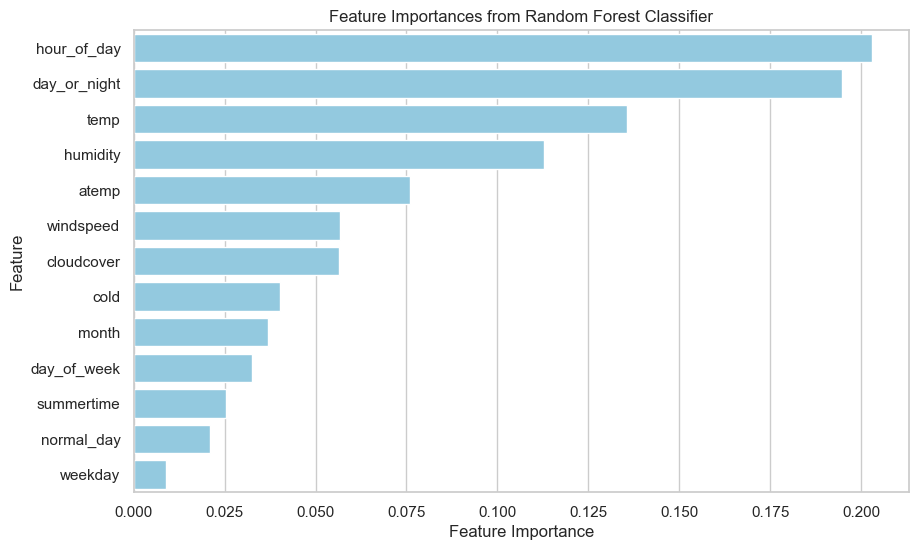

In [5]:
rf_classifier = best_model.named_steps['rf']

# Retrieve feature importances
importances = rf_classifier.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot using Seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Classifier')
plt.show()

In [6]:
#Preprocess the test data

test_set = pd.read_csv(os.path.abspath("../data/test_data_fall2024.csv"))

test_set['day_or_night'] = test_set['hour_of_day'].apply(lambda x: 1 if 8 <= x < 21 else 0)

test_set['normal_day'] = (~((test_set['summertime'] == 1) | (test_set['holiday'] == 1) | (test_set['weekday'] == 0))).astype(int)

test_set['cold'] = test_set['temp'].apply(lambda x: 1 if x <= 8 else 0)

test_set['atemp'] = (243.04 * (np.log(test_set['humidity']/100)
                        + (17.625 * test_set['dew']) / (243.04 + test_set['dew']))) / (17.625 - np.log(test_set['humidity']/100)
                        - (17.625 * test_set['dew']) / (243.04 + test_set['dew']))

#Remove bad features
test_set = test_set.drop(['snow', 'snowdepth', 'holiday', 'visibility', 'precip', 'dew'], axis=1)

test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hour_of_day   400 non-null    int64  
 1   day_of_week   400 non-null    int64  
 2   month         400 non-null    int64  
 3   weekday       400 non-null    int64  
 4   summertime    400 non-null    int64  
 5   temp          400 non-null    float64
 6   humidity      400 non-null    float64
 7   windspeed     400 non-null    float64
 8   cloudcover    400 non-null    float64
 9   day_or_night  400 non-null    int64  
 10  normal_day    400 non-null    int32  
 11  cold          400 non-null    int64  
 12  atemp         400 non-null    float64
dtypes: float64(5), int32(1), int64(7)
memory usage: 39.2 KB


In [17]:
test_pred = best_model.predict(test_set)

print(test_pred)

predictions_df = pd.DataFrame([test_pred])

predictions_df.info()

print(predictions_df.shape)

predictions_df.to_csv(os.path.abspath("../data/predictions.csv"), index=False, header=False)

[0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 400 entries, 0 to 399
dtypes: int64(400)
memory usage: 3.2 KB
(1, 400)
